**Importing the Necessary Libraries**

In [70]:
%load_ext autoreload
%autoreload 2
import helper_functions as hp
import numpy as np
import pandas as pd
import keras_tuner
import gc
import cv2
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import mobilenet_v2
from sklearn.utils import class_weight

## 4 1 2 bands for near infrared
## 1 2 3 for normal rgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## Uncomment the code below to check that your tensorflow is using
## available GPU's

# import tensorflow as tf
# tf.version.VERSION
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# ##device_lib.list_local_devices()

Num GPUs Available:  2


# **Loading in Data** - Functions to load in data and preprocessor
    
    The first thing we need to do is read in the different fire images and corresponding labels.
    The function segmented_dataset_reader will handle this. In order to do this pass in the foldername of the fire data you want to read in and whether you are reading in that data as a training or testing set.

    This will output the dataset into two or three numpy arrays. The amount depends on if the train_bool flag was set to true or false. that will contain the images in one array, then the geo-reference data in another array and then finally the labels in a final array.

    Quick tip if a factor int parameter is passed into the segmented_dataset_reader function then only a portion of the entire dataset will be read in. This is usefull for testing on smaller datasets in order to speed up computation
    i.e hp.segmented_dataset_reader('foldername', factor = 10) >>> this will only read in 1/10 of the data

In [45]:
Pocket_images,Pocket_geo,Pocket_labels = hp.segmented_dataset_reader('PocketN_6_64', factor = 10)
Nuns_images, Nuns_labels = hp.segmented_dataset_reader('NunsN_6_64', train_bool=True, factor = 10)
Tubbs_images, Tubbs_labels = hp.segmented_dataset_reader('tubbsN_6_64', train_bool=True, factor = 10)

reading in 718 images
reading in 1366 images
reading in 1014 images


In [46]:
## This cell is used to verify that the images and labels were read in correctly
## images should be a 4D array of shape (numfiles, height, width, channels)
## labels should be a 3D array of shape (numfiles, height, width)
## datatype for images should be float 32 
## datatype for labels should be uint8
print(Pocket_images.shape, Pocket_labels.shape)
print(Nuns_images.shape, Nuns_labels.shape)
print(Tubbs_images.shape, Tubbs_labels.shape)

assert Pocket_images.ndim == 4
assert Nuns_images.ndim == 4
assert Tubbs_images.ndim == 4

assert Pocket_labels.ndim == 3
assert Nuns_labels.ndim == 3
assert Tubbs_labels.ndim == 3

assert Pocket_images.dtype == 'float32'
assert Nuns_images.dtype == 'float32'
assert Tubbs_images.dtype == 'float32'

assert Pocket_labels.dtype == 'uint8'
assert Nuns_labels.dtype == 'uint8'
assert Tubbs_labels.dtype == 'uint8'


(718, 128, 128, 3) (718, 128, 128)
(1366, 128, 128, 3) (1366, 128, 128)
(1014, 128, 128, 3) (1014, 128, 128)


# **Data Preprocessing:**

Now that the images and labels are read in correctly we need to do a bit of preprocessing before we feed then into our networks

* we need to make sure the labels only contain values from 0 - 5:
    This will be checked with np.unique. Since the labels from the original data are 1 - 6 for fire damage and 0 for background we need to subtract 1 from all values greater then 0. Since the data was created to only have a few pixels of background, setting 5% fire damage and background as the same shouldn't cause an issue down the line in our networks

In [49]:
## checking to see if our labels have a valid range ie (1-6) 
## maybe including 0 depending on how much of the dataset is read in
print(np.unique(Pocket_labels, return_counts=True))
print(np.unique(Nuns_labels, return_counts=True))
print(np.unique(Tubbs_labels, return_counts=True))

expected_labels = np.array([1, 2, 3, 4, 5, 6])
assert np.all(np.in1d(expected_labels, np.unique(Pocket_labels)))
assert np.all(np.in1d(expected_labels, np.unique(Nuns_labels)))
assert np.all(np.in1d(expected_labels, np.unique(Tubbs_labels)))

(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([      1, 2645655, 2420751, 1802745, 1212100,  865902, 2816558]))
(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([       2,  1405556,  2566197,  2525991,  2082224,  1792344,
       12008230]))
(array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([      3, 1636514, 2603359, 1678029, 1207479, 1293314, 8194678]))


In [50]:
## will subtract 1 from all labels greater then 0 in order to change the range of our data
## from 1 - 6 to 0 - 5 
## ONLY RUN THIS CELL ONCE
Pocket_labels = np.where(Pocket_labels != 0, Pocket_labels - 1, Pocket_labels)
Nuns_labels = np.where(Nuns_labels != 0, Nuns_labels - 1, Nuns_labels)
Tubbs_labels = np.where(Tubbs_labels != 0, Tubbs_labels - 1, Tubbs_labels)

In [51]:
## labels should now be in the range 0 - 5

print(np.unique(Pocket_labels, return_counts=True))
print(np.unique(Nuns_labels, return_counts=True))
print(np.unique(Tubbs_labels, return_counts=True))

expected_labels = np.array([0, 1, 2, 3, 4, 5])
assert np.array_equal(np.unique(Pocket_labels), expected_labels)
assert np.array_equal(np.unique(Nuns_labels),expected_labels)
assert np.array_equal(np.unique(Tubbs_labels),expected_labels)

(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([2645656, 2420751, 1802745, 1212100,  865902, 2816558]))
(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([ 1405558,  2566197,  2525991,  2082224,  1792344, 12008230]))
(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([1636517, 2603359, 1678029, 1207479, 1293314, 8194678]))


# **Displaying images and labels**

This is just used to display a few random images in order once again make sure our data was read in correctly

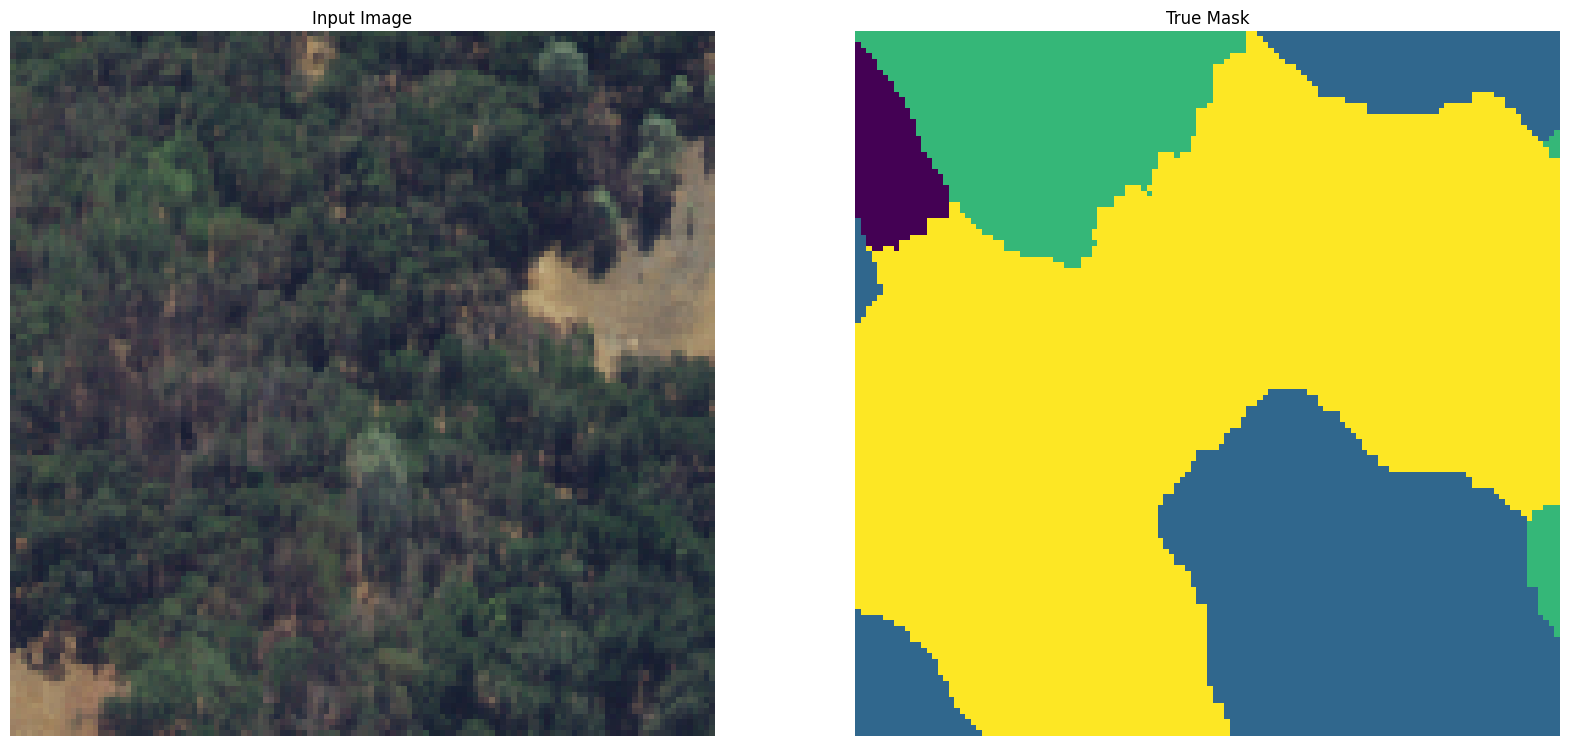

In [65]:
img = Pocket_images[400]/255.0 # divide by 255 since images are float but with range 0-255 right now
lbl = Pocket_labels[400]
hp.display([img,lbl])


# **Creating training and testing datasets**


Now will be be separating our data out into training and testing datasets. We are using a leave one out method of training our networks. These means we are going to train out network on two fires and test on the third.
In order to do this we will concatenate the arrays of two fires together and then designate the other fire as the test fire.



In [66]:
train_images = np.concatenate((Pocket_images, Tubbs_images), axis=0)
train_labels = np.concatenate((Pocket_labels, Tubbs_labels), axis=0)
test_images = Nuns_images
test_labels = Nuns_labels

In [10]:
del Pocket_images
del Pocket_labels
del Nuns_images
del Nuns_labels
del Tubbs_images
del Tubbs_labels

In [67]:
print(train_images.shape, train_labels.shape)
print(train_images.dtype, train_labels.dtype)
print(train_images.max(),train_images.min())
print(np.unique(train_labels, return_counts=True))
print(test_images.shape, test_labels.shape)
print(test_images.dtype, test_labels.dtype)

(1732, 128, 128, 3) (1732, 128, 128)
float32 uint8
223.0 4.0
(array([0, 1, 2, 3, 4, 5], dtype=uint8), array([ 4282173,  5024110,  3480774,  2419579,  2159216, 11011236]))
(1366, 128, 128, 3) (1366, 128, 128)
float32 uint8


# **Class weights and callbacks**

Now that we have created our training and testing dataset we can move on to setting up some parameters for our networks

* First we are generating our class weights - These will given to our loss function in order to help correct for any class imbalance issues in our dataset

* Next we are setting up our callbacks for the network - These callbacks are reduce_lr and early_stopping


In [68]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes= np.unique(train_labels.flatten()), y = train_labels.flatten())
print(class_weights)

[1.10446604 0.94136368 1.35875373 1.95468495 2.19038515 0.42951715]


In [69]:
#All my callback are called here
r_lr = hp.reduce_lr()
e_stop = hp.early_stop()
_callbacks = [r_lr, e_stop]
gc.collect()

32189

**Hyper parameter optimization** - hyperparameter optimzation using keras tuner

In [13]:
#simple unet keras tuner builder
def build_Unet(hpf): 
        model = hp.build_unet_model(6,act='elu', drop=0.3, drop2=0.2,
                                drop_bool=True, drop_bool2=False,
                                filter=48, act2='leaky_relu', gamma=1, lr=0.003, opt='adam')
        return model


In [14]:
#keras_tuner hyperband object
_meaniou = keras_tuner.Objective('val_mean_io_u', 'max')
tuner = keras_tuner.RandomSearch(
    hypermodel= build_Unet,
    objective= _meaniou,
    max_trials = 30,
    directory="hp_results",
    project_name="canopy_fire",
    overwrite=True,
)

2023-04-19 10:13:32.040818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2023-04-19 10:13:32.041036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9450 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


In [16]:
#performs hyper parameter optimization
tuner.search(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size = 32,
    epochs = 4,
)

Trial 30 Complete [00h 04m 08s]
val_mean_io_u: 0.337273508310318

Best val_mean_io_u So Far: 0.337273508310318
Total elapsed time: 01h 36m 08s
INFO:tensorflow:Oracle triggered exit


In [17]:
tuner.results_summary()

Results summary
Results in hp_results/canopy_fire
Showing 10 best trials
Objective(name="val_mean_io_u", direction="max")

Trial 29 summary
Hyperparameters:
filters: 48
activation2: leaky_relu
gamma: 1
lr: 0.002280979101947618
Score: 0.337273508310318

Trial 17 summary
Hyperparameters:
filters: 48
activation2: leaky_relu
gamma: 1
lr: 0.004058869337820706
Score: 0.333394855260849

Trial 18 summary
Hyperparameters:
filters: 48
activation2: leaky_relu
gamma: 1
lr: 0.0038974298555901656
Score: 0.3323601186275482

Trial 21 summary
Hyperparameters:
filters: 32
activation2: leaky_relu
gamma: 1
lr: 0.005242356927402547
Score: 0.33228087425231934

Trial 04 summary
Hyperparameters:
filters: 48
activation2: relu
gamma: 2
lr: 0.004711734276857738
Score: 0.3262912929058075

Trial 11 summary
Hyperparameters:
filters: 48
activation2: leaky_relu
gamma: 2
lr: 0.004672024591090819
Score: 0.325443834066391

Trial 14 summary
Hyperparameters:
filters: 16
activation2: leaky_relu
gamma: 1
lr: 0.0042356479569

In [18]:
count = 10
best_hp = tuner.get_best_hyperparameters(count)
mylist = []
for i in range(count):
    mylist.append(best_hp[i].values)
print(mylist)

[{'filters': 48, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.002280979101947618}, {'filters': 48, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.004058869337820706}, {'filters': 48, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.0038974298555901656}, {'filters': 32, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.005242356927402547}, {'filters': 48, 'activation2': 'relu', 'gamma': 2, 'lr': 0.004711734276857738}, {'filters': 48, 'activation2': 'leaky_relu', 'gamma': 2, 'lr': 0.004672024591090819}, {'filters': 16, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.0042356479569323905}, {'filters': 32, 'activation2': 'relu', 'gamma': 2, 'lr': 0.0044862339105765}, {'filters': 16, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.0021387126805189095}, {'filters': 48, 'activation2': 'leaky_relu', 'gamma': 1, 'lr': 0.003082818673647337}]


In [19]:
df = pd.DataFrame(mylist)
df

,filters,activation2,gamma,lr
0,48,leaky_relu,1,0.002281
1,48,leaky_relu,1,0.004059
2,48,leaky_relu,1,0.003897
3,32,leaky_relu,1,0.005242
4,48,relu,2,0.004712
5,48,leaky_relu,2,0.004672
6,16,leaky_relu,1,0.004236
7,32,relu,2,0.004486
8,16,leaky_relu,1,0.002139
9,48,leaky_relu,1,0.003083


**optimized simple unet fitting**

In [16]:
model = hp.build_unet_model(num_class = 6, weights = class_weights)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 128, 128, 48  219        ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 128, 128, 48  2784       ['separable_conv2d[0][0]']       
 onv2D)                         )                                                             

In [18]:
gc.collect()

0

In [19]:
history = model.fit(train_images/255.0, train_labels, epochs=50, validation_data=(test_images/255.0, test_labels), batch_size=16, callbacks = _callbacks, shuffle=True)  #beat 0.3770 #beat 0.3314

Epoch 1/50
1084/1084 [==============================] - ETA: 0s - loss: 1.1085 - accuracy: 0.4740 - mean_io_u: 0.2508

2023-05-09 20:40:03.449633: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 20:40:03.449667: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1084/1084 [==============================] - 115s 103ms/step - loss: 1.1085 - accuracy: 0.4740 - mean_io_u: 0.2508 - val_loss: 1.5636 - val_accuracy: 0.5645 - val_mean_io_u: 0.2133 - lr: 0.0030
Epoch 2/50
1084/1084 [==============================] - 109s 101ms/step - loss: 0.9733 - accuracy: 0.5220 - mean_io_u: 0.2973 - val_loss: 1.0336 - val_accuracy: 0.5580 - val_mean_io_u: 0.2775 - lr: 0.0030
Epoch 3/50
1084/1084 [==============================] - 110s 102ms/step - loss: 0.9412 - accuracy: 0.5306 - mean_io_u: 0.3072 - val_loss: 1.4697 - val_accuracy: 0.6388 - val_mean_io_u: 0.2562 - lr: 0.0030
Epoch 4/50
1083/1084 [============================>.] - ETA: 0s - loss: 0.8796 - accuracy: 0.5594 - mean_io_u: 0.3291
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
1084/1084 [==============================] - 110s 102ms/step - loss: 0.8795 - accuracy: 0.5594 - mean_io_u: 0.3291 - val_loss: 0.8406 - val_accuracy: 0.6567 - val_mean_io_u: 0.3296 - lr: 0.0030
Epoch 5/5

In [22]:
model.save('Models/simple_seg_model_full_6class_PocketTubbs.tf', overwrite=True)
# model= keras.models.load_model("simple_seg_model.h5")

INFO:tensorflow:Assets written to: Models/simple_seg_model_full_6class_PocketTubbs.tf/assets


INFO:tensorflow:Assets written to: Models/simple_seg_model_full_6class_PocketTubbs.tf/assets


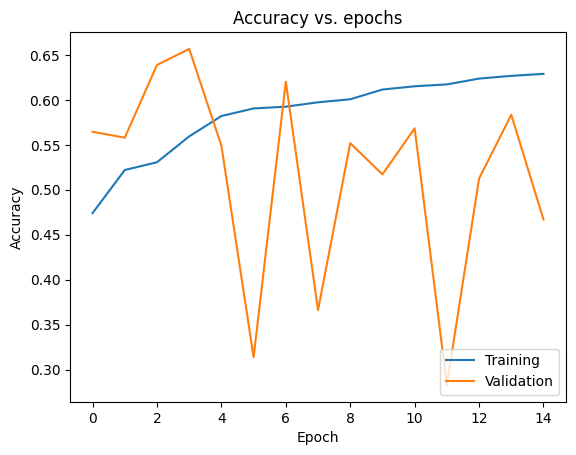

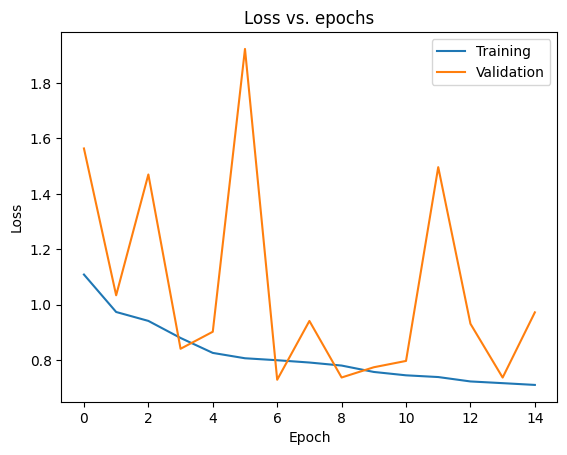

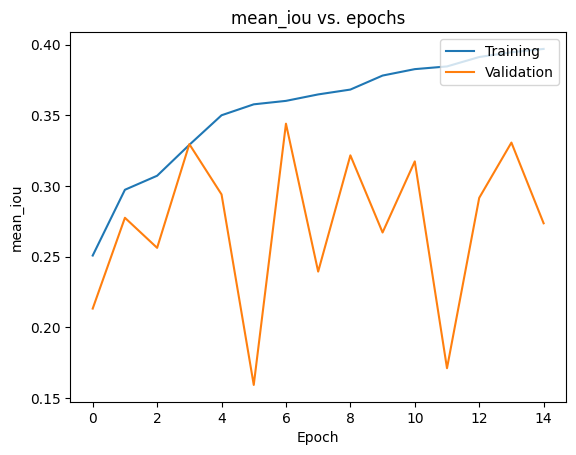

In [20]:
hp.plot_accuracy(history)
hp.plot_loss(history)
hp.plot_meaniou(history)

2023-05-09 23:07:48.848023: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 23:07:48.848054: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 23:07:48.856624: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 23:07:48.856645: W tensorflow/core/common_runtime/bfc_allocato

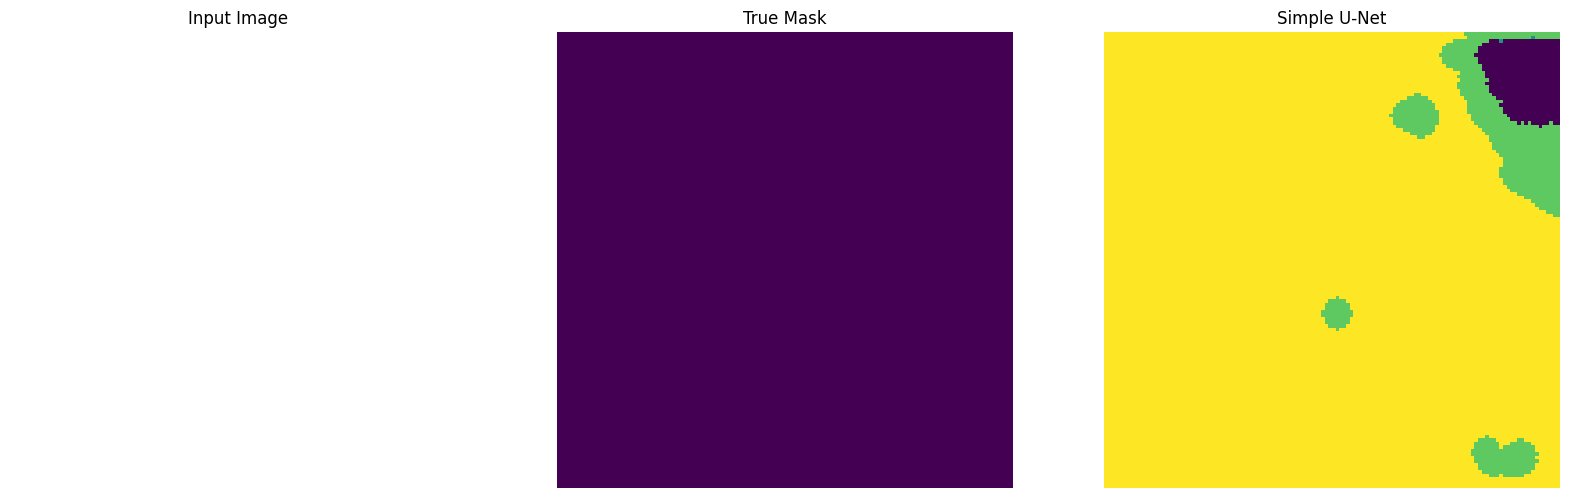

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


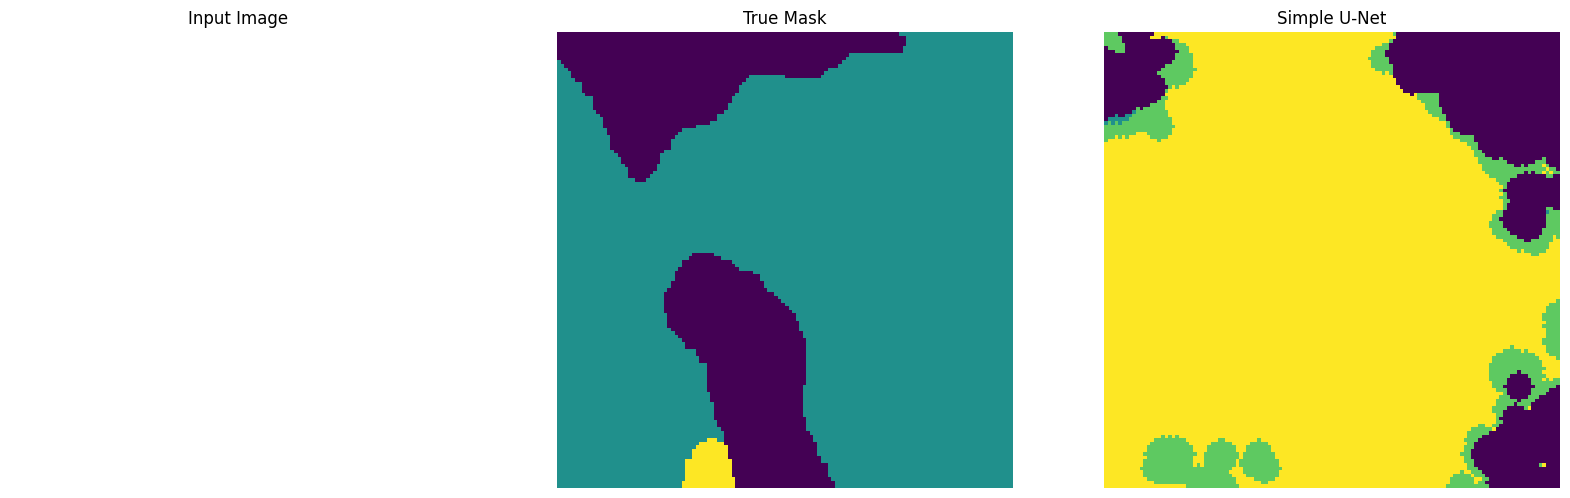

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


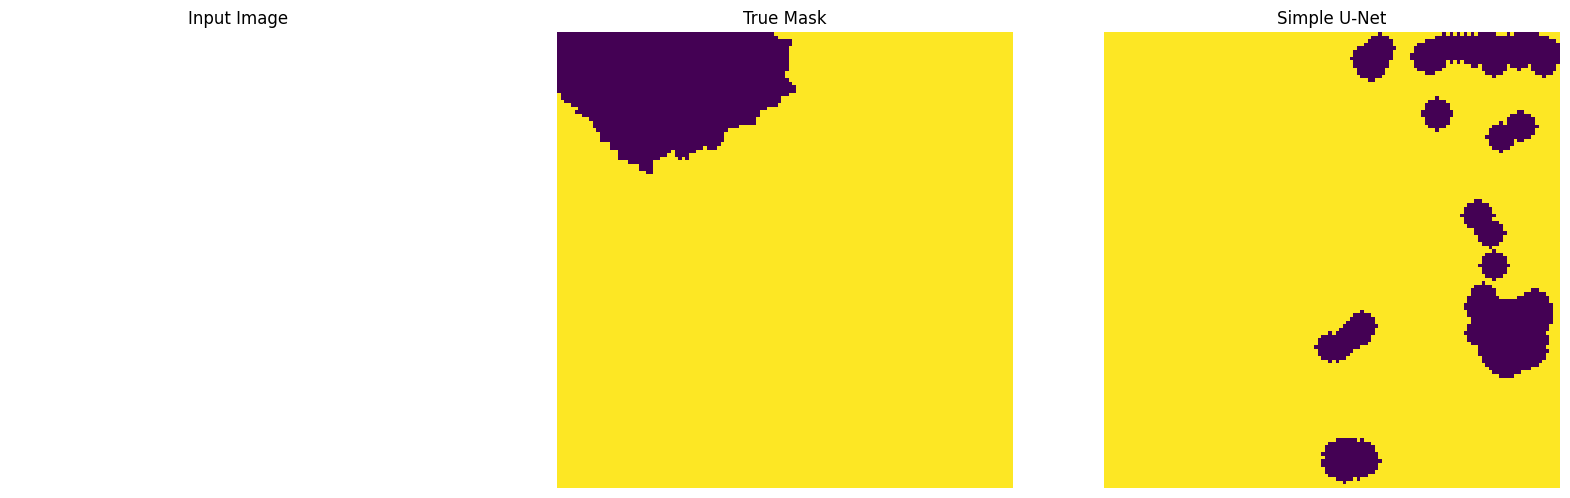

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


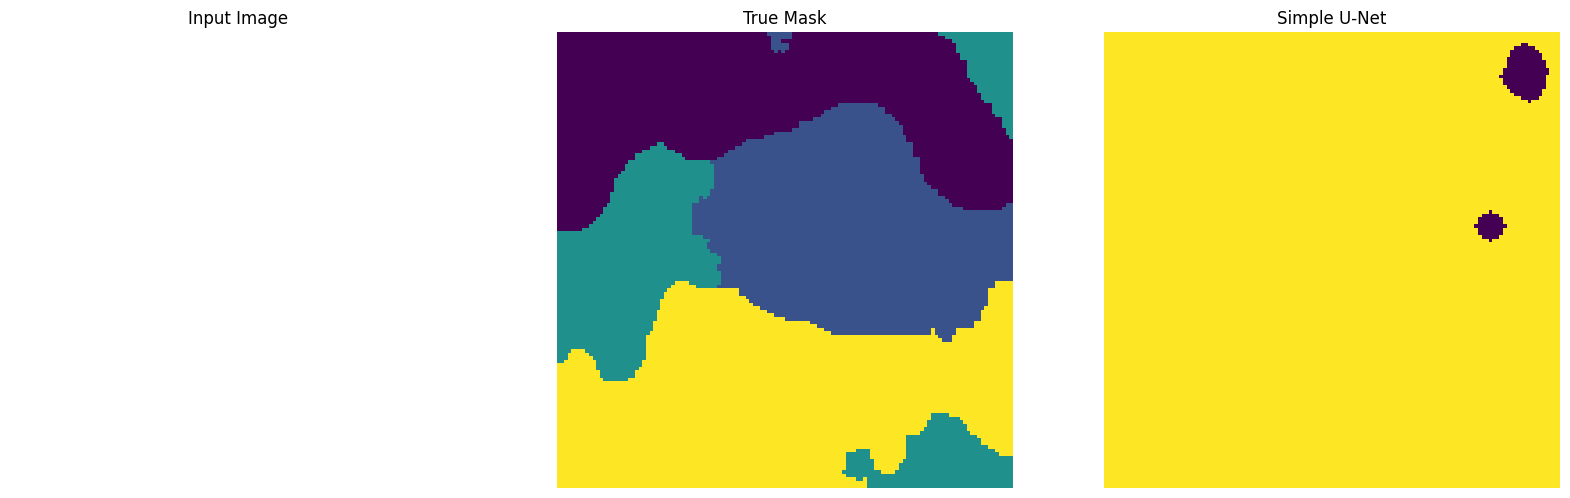

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


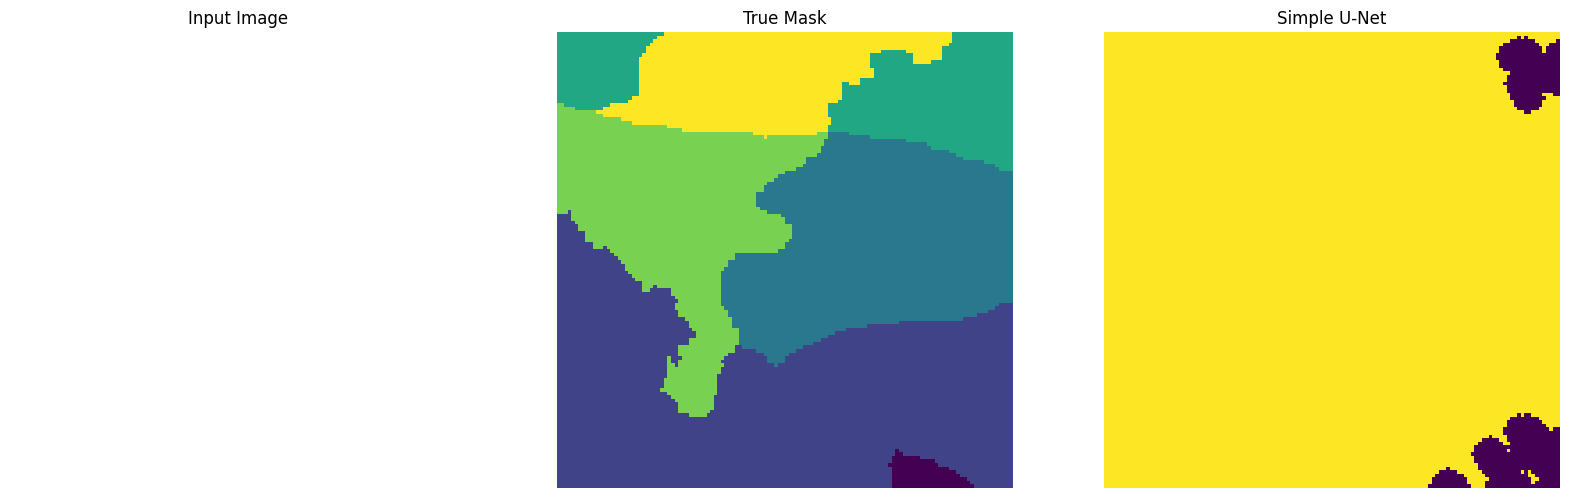

In [21]:
hp.show_predictions(model, test_images[100:105], test_labels[100:105], 5, "Simple U-Net")
#del model

**Hyper Parameter optimization of mobile Unet** - using keras tuner and hyperband


In [9]:
def build_Mobile_Unet(hpf):
        model = hp.mobile_unet_model(6, trainable = 2, batch_bool = True, opt = 'adam', lr = 0.004, gamma = 1)
        return model

In [23]:
_meaniou = keras_tuner.Objective('val_mean_io_u', 'max')
tuner = keras_tuner.RandomSearch(
    hypermodel= build_Mobile_Unet,
    objective= _meaniou,
    max_trials = 30,
    directory="hp_results",
    project_name="canopy_fire",
    overwrite=True,
)

In [24]:
tuner.search(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size = 32,
    epochs = 4,
)

Trial 30 Complete [00h 01m 24s]
val_mean_io_u: 0.26924198865890503

Best val_mean_io_u So Far: 0.283194899559021
Total elapsed time: 00h 42m 12s
INFO:tensorflow:Oracle triggered exit


In [25]:
count = 10
best_hp = tuner.get_best_hyperparameters(count)
mylist = []
for i in range(count):
    mylist.append(best_hp[i].values)
print(mylist)

[{'training layers': 2, 'lr': 0.00454075841255362}, {'training layers': 2, 'lr': 0.005490222637767316}, {'training layers': 2, 'lr': 0.004242922659531865}, {'training layers': 2, 'lr': 0.005773107053690844}, {'training layers': 2, 'lr': 0.0031312733259334018}, {'training layers': 5, 'lr': 0.0034807827859902126}, {'training layers': 2, 'lr': 0.005706033148428903}, {'training layers': 3, 'lr': 0.005498696508094774}, {'training layers': 2, 'lr': 0.0035225490910381625}, {'training layers': 3, 'lr': 0.0038647162039910287}]


In [26]:
df = pd.DataFrame(mylist)
df

,training layers,lr
0,2,0.004541
1,2,0.005490
2,2,0.004243
3,2,0.005773
4,2,0.003131
5,5,0.003481
6,2,0.005706
7,3,0.005499
8,2,0.003523
9,3,0.003865


**Fitting the optimized mobile Unet**

In [32]:
keras.backend.clear_session()
model_mobile = hp.mobile_unet_model(output_channels=6, weights=class_weights)
model_mobile.summary()
gc.collect()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_1[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

7472

In [34]:
gc.collect()


0

In [24]:
history_mobile = model_mobile.fit(mobilenet_v2.preprocess_input(train_images), train_labels, epochs=50, batch_size=16,
                                  validation_data=(mobilenet_v2.preprocess_input(test_images), test_labels),
                                  callbacks=_callbacks, shuffle=True)  #.3175

Epoch 1/50
542/542 [==============================] - 39s 68ms/step - loss: 1.1342 - accuracy: 0.4775 - mean_io_u: 0.2530 - val_loss: 1.0913 - val_accuracy: 0.5300 - val_mean_io_u: 0.2109 - lr: 0.0040
Epoch 2/50
542/542 [==============================] - 32s 60ms/step - loss: 1.0732 - accuracy: 0.5000 - mean_io_u: 0.2730 - val_loss: 0.9624 - val_accuracy: 0.4787 - val_mean_io_u: 0.2308 - lr: 0.0040
Epoch 3/50
542/542 [==============================] - 33s 60ms/step - loss: 1.0448 - accuracy: 0.5106 - mean_io_u: 0.2818 - val_loss: 0.9104 - val_accuracy: 0.5875 - val_mean_io_u: 0.2786 - lr: 0.0040
Epoch 4/50
541/542 [============================>.] - ETA: 0s - loss: 1.0250 - accuracy: 0.5178 - mean_io_u: 0.2881
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0020000000949949026.
542/542 [==============================] - 33s 61ms/step - loss: 1.0248 - accuracy: 0.5179 - mean_io_u: 0.2881 - val_loss: 0.9248 - val_accuracy: 0.5857 - val_mean_io_u: 0.2837 - lr: 0.0040
Epoch 5/50
542/

In [65]:
#model_mobile = keras.models.load_model("mobilenet_seg_model_full.tf")

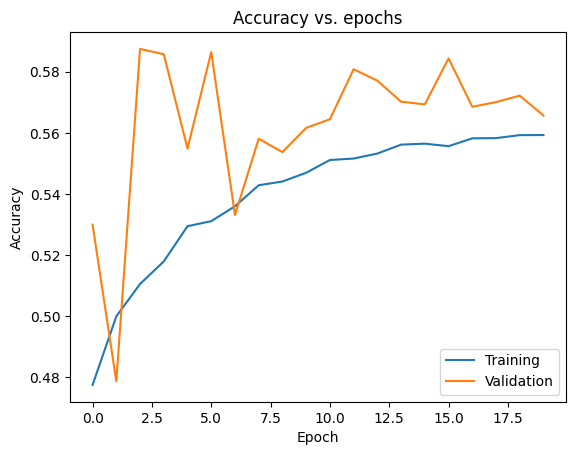

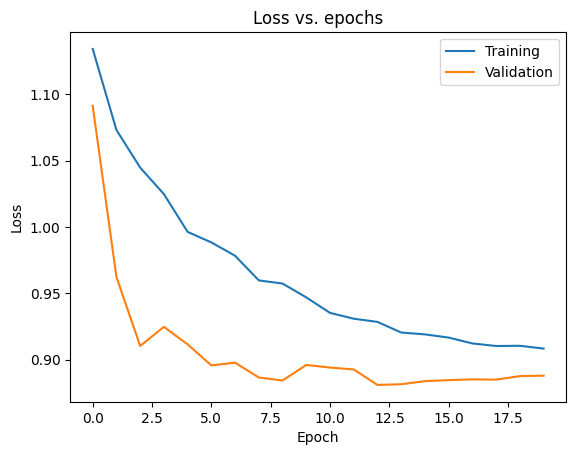

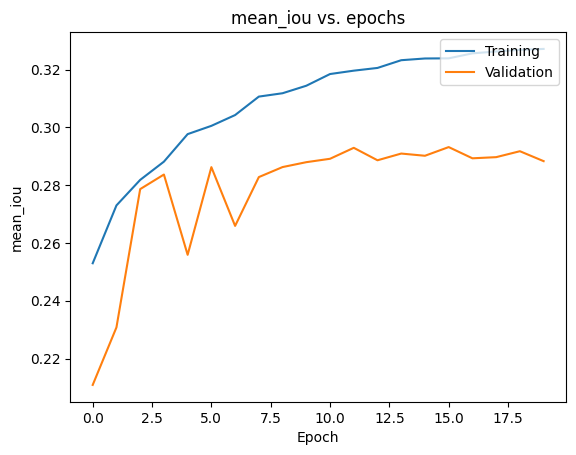

In [25]:
hp.plot_accuracy(history_mobile)
hp.plot_loss(history_mobile)
hp.plot_meaniou(history_mobile)

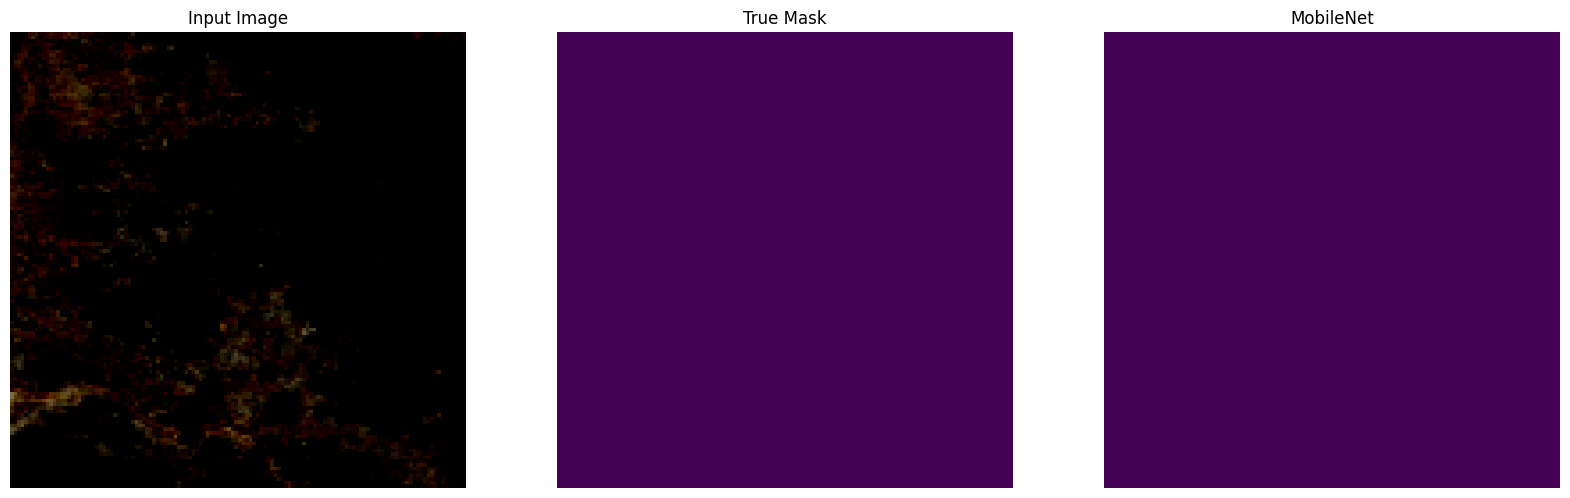

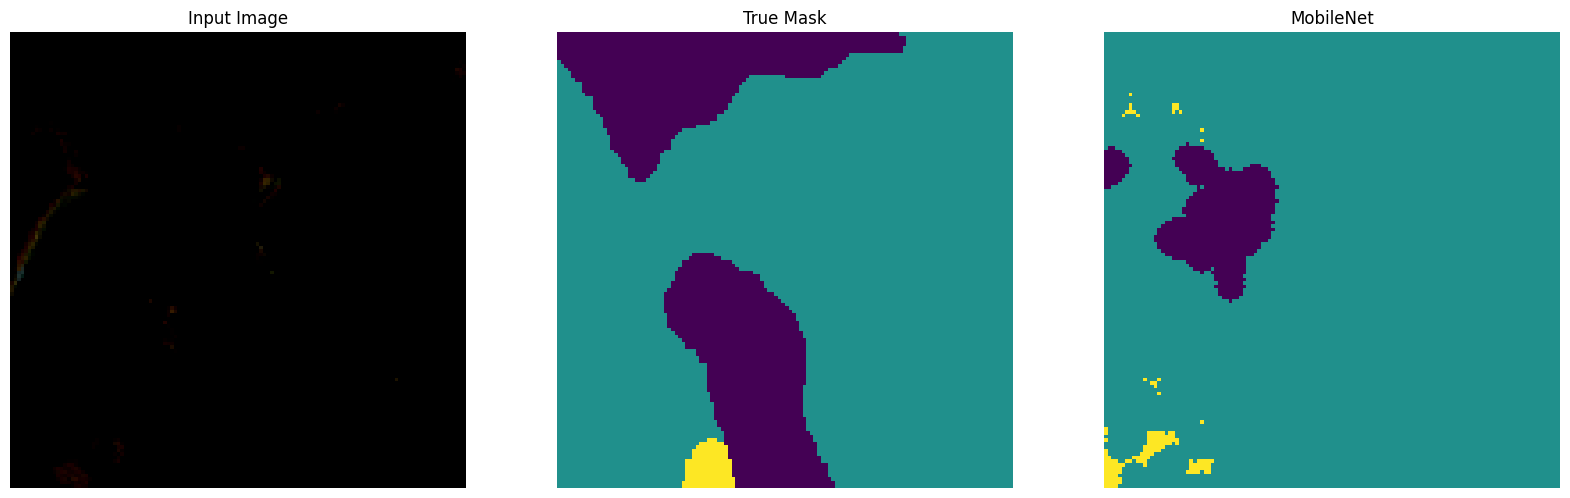

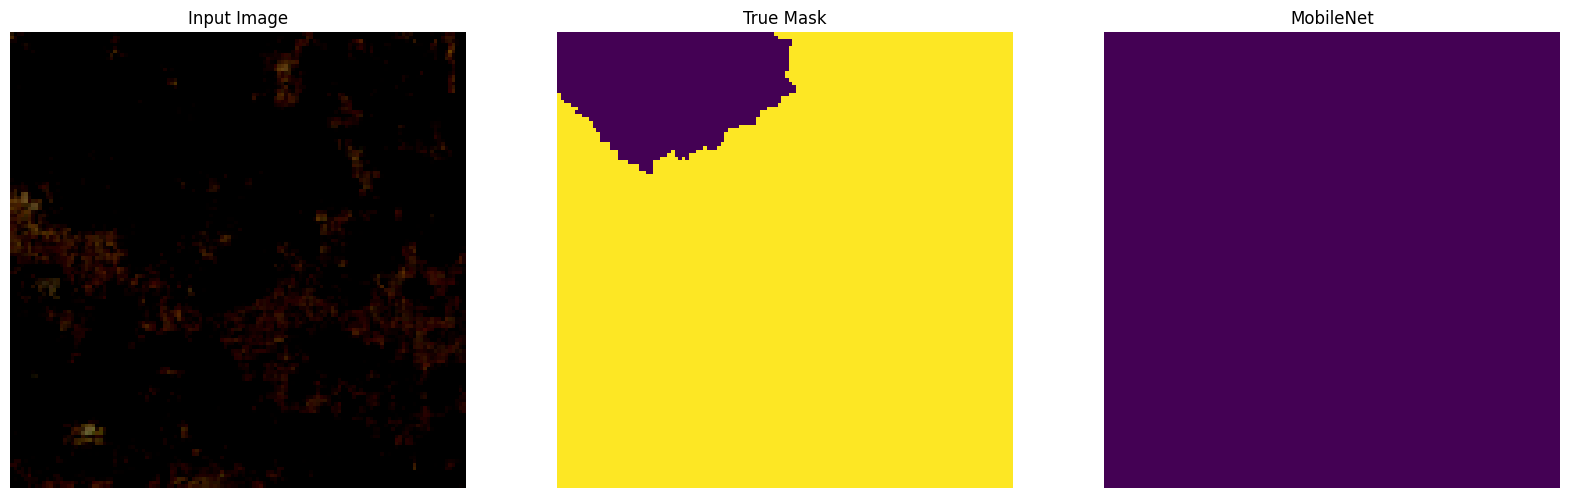

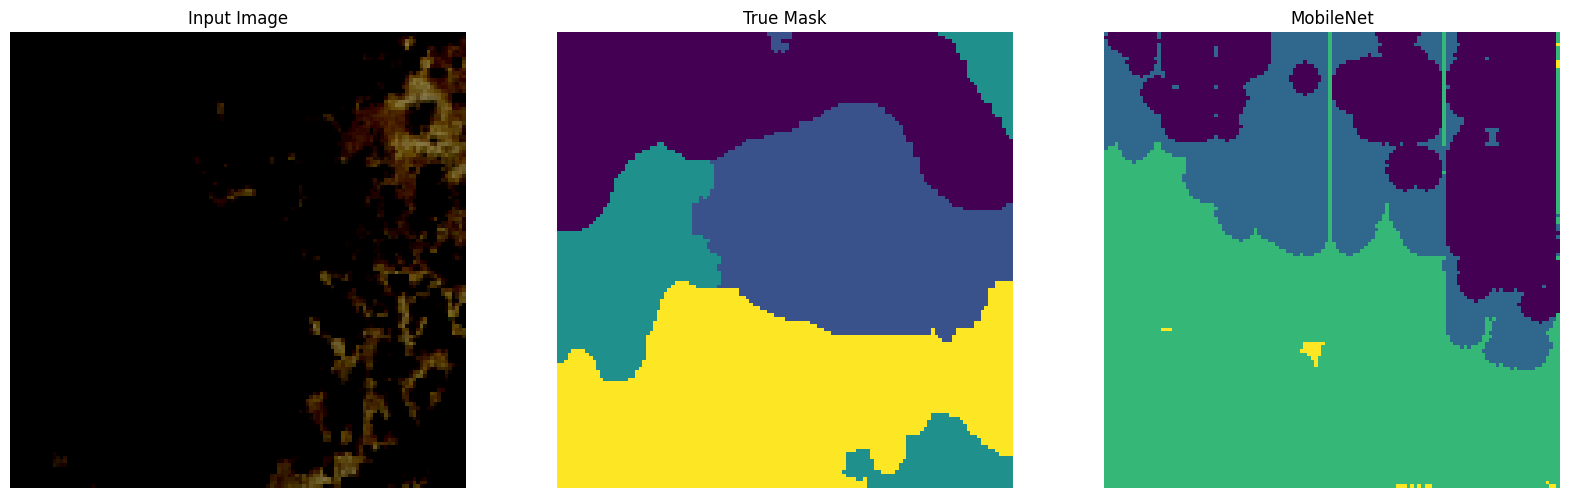

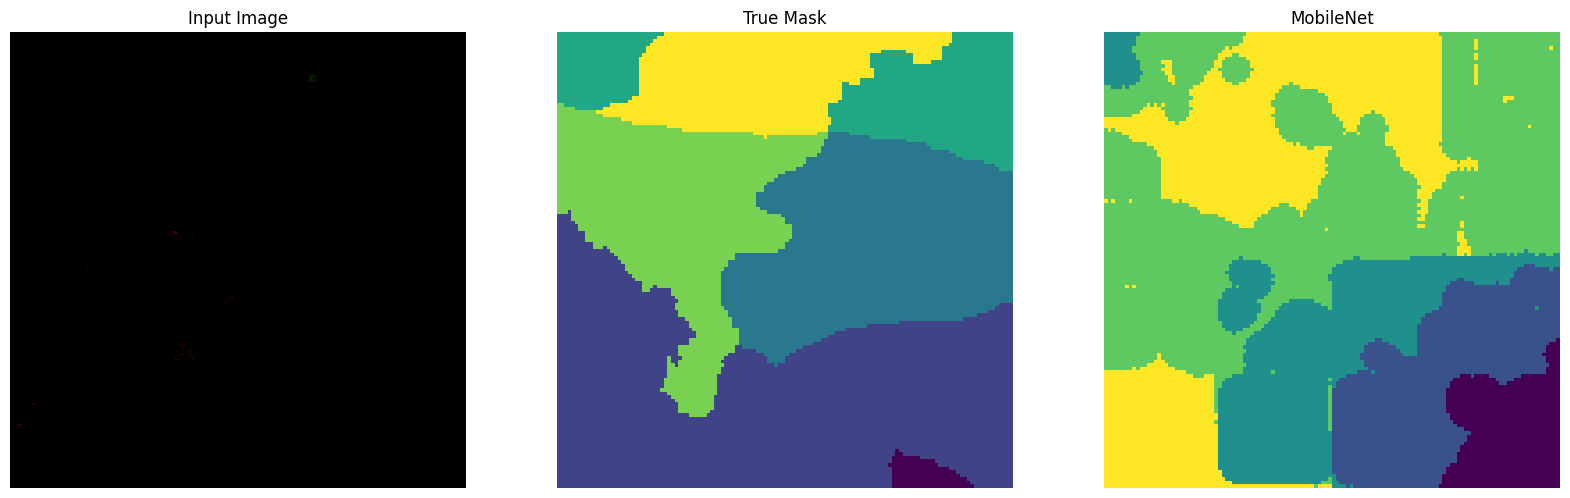

In [26]:
hp.show_predictions(model_mobile, test_images[100:105], test_labels[100:105], 5, "MobileNet")

In [27]:
model_mobile.save('Models/mobilenet_seg_model_full_6class_PocketTubbs.tf', overwrite=True)

INFO:tensorflow:Assets written to: Models/mobilenet_seg_model_full_6class_PocketTubbs.tf/assets


INFO:tensorflow:Assets written to: Models/mobilenet_seg_model_full_6class_PocketTubbs.tf/assets


**Setting up deeplab keras tuner**


In [9]:
def build_Deeplab_Unet(hpf):
        _drop_rate = hpf.Choice("drop_rate",[0.1,0.3,0.4])
        _drop_rate2 = hpf.Choice("drop_rate2",[0.1,0.2,0.3,0.4])
        _batch_bool = hpf.Boolean("batch_bool")
        _batch_bool2 = hpf.Boolean("batch_bool2")
        _lr = hpf.Float("lr", min_value=0.003, max_value=0.006, sampling="linear")
        _gamma = hpf.Choice("gamma", [1,2,3])
        model = hp.DeeplabV3Plus(image_size=128, num_classes=6,drop_rate= _drop_rate, drop_rate2=_drop_rate2,
                                 batch_bool= _batch_bool, batch_bool2 = _batch_bool2, opt = 'SGD', lr = _lr, gamma = _gamma)
        return model

In [10]:
_meaniou = keras_tuner.Objective('val_mean_io_u', 'max')
tuner = keras_tuner.RandomSearch(
    hypermodel= build_Deeplab_Unet,
    objective= _meaniou,
    max_trials = 20,
    directory="hp_results",
    project_name="canopy_fire",
    overwrite=False,
)

INFO:tensorflow:Reloading Tuner from hp_results/canopy_fire/tuner0.json


In [11]:
tuner.search(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size = 32,
    epochs = 4,
)

Trial 20 Complete [00h 03m 16s]
val_mean_io_u: 0.3205831050872803

Best val_mean_io_u So Far: 0.3342233896255493
Total elapsed time: 00h 19m 40s
INFO:tensorflow:Oracle triggered exit


In [11]:
count = 10
best_hp = tuner.get_best_hyperparameters(count)
mylist = []
for i in range(count):
    mylist.append(best_hp[i].values)
print(mylist)

[{'drop_rate': 0.4, 'drop_rate2': 0.2, 'batch_bool': True, 'batch_bool2': True, 'lr': 0.005367958117152761, 'gamma': 1}, {'drop_rate': 0.1, 'drop_rate2': 0.3, 'batch_bool': False, 'batch_bool2': False, 'lr': 0.005782724486729771, 'gamma': 1}, {'drop_rate': 0.3, 'drop_rate2': 0.3, 'batch_bool': False, 'batch_bool2': False, 'lr': 0.0050594386264619035, 'gamma': 3}, {'drop_rate': 0.3, 'drop_rate2': 0.1, 'batch_bool': False, 'batch_bool2': False, 'lr': 0.003941540676815267, 'gamma': 2}, {'drop_rate': 0.4, 'drop_rate2': 0.3, 'batch_bool': False, 'batch_bool2': True, 'lr': 0.003172746237806152, 'gamma': 2}, {'drop_rate': 0.3, 'drop_rate2': 0.4, 'batch_bool': False, 'batch_bool2': True, 'lr': 0.003853109074008468, 'gamma': 3}, {'drop_rate': 0.4, 'drop_rate2': 0.3, 'batch_bool': True, 'batch_bool2': False, 'lr': 0.0033518332121181783, 'gamma': 2}, {'drop_rate': 0.3, 'drop_rate2': 0.3, 'batch_bool': False, 'batch_bool2': True, 'lr': 0.004864675432932375, 'gamma': 3}, {'drop_rate': 0.1, 'drop_ra

In [12]:
df = pd.DataFrame(mylist)
df

,drop_rate,drop_rate2,batch_bool,batch_bool2,lr,gamma
0,0.4,0.2,True,True,0.005368,1
1,0.1,0.3,False,False,0.005783,1
2,0.3,0.3,False,False,0.005059,3
3,0.3,0.1,False,False,0.003942,2
4,0.4,0.3,False,True,0.003173,2
5,0.3,0.4,False,True,0.003853,3
6,0.4,0.3,True,False,0.003352,2
7,0.3,0.3,False,True,0.004865,3
8,0.1,0.3,False,False,0.003530,2
9,0.1,0.4,False,True,0.004225,2


In [9]:
keras.backend.clear_session()
model_deeplab = hp.DeeplabV3Plus(image_size=128, num_classes=6, weight=class_weights)
model_deeplab.summary()
gc.collect()

2023-05-10 00:40:14.577053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 00:40:15.321858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2023-05-10 00:40:15.322888: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9444 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

548

In [10]:
dlab_history = model_deeplab.fit(train_images/255.0, train_labels, epochs=50, batch_size=16,
                                 validation_data=(test_images/255.0, test_labels),
                                 callbacks=_callbacks, shuffle=True)

Epoch 1/50


2023-05-10 00:40:28.912994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-05-10 00:40:31.477186: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-10 00:40:31.477218: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.72GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1084/1084 [==============================] - ETA: 0s - loss: 1.1274 - accuracy: 0.4846 - mean_io_u: 0.2573

2023-05-10 00:42:12.383462: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-10 00:42:12.383492: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-10 00:42:12.406425: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-10 00:42:12.406447: W tensorflow/core/common_runtime/bfc_allocato

1084/1084 [==============================] - 108s 93ms/step - loss: 1.1274 - accuracy: 0.4846 - mean_io_u: 0.2573 - val_loss: 1.2237 - val_accuracy: 0.3092 - val_mean_io_u: 0.1719 - lr: 0.0050
Epoch 2/50
1084/1084 [==============================] - 98s 90ms/step - loss: 0.9974 - accuracy: 0.5223 - mean_io_u: 0.2937 - val_loss: 1.1112 - val_accuracy: 0.6005 - val_mean_io_u: 0.2420 - lr: 0.0050
Epoch 3/50
1084/1084 [==============================] - 99s 91ms/step - loss: 0.9381 - accuracy: 0.5410 - mean_io_u: 0.3113 - val_loss: 0.9619 - val_accuracy: 0.4981 - val_mean_io_u: 0.2615 - lr: 0.0050
Epoch 4/50
1084/1084 [==============================] - ETA: 0s - loss: 0.8937 - accuracy: 0.5606 - mean_io_u: 0.3289
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
1084/1084 [==============================] - 99s 91ms/step - loss: 0.8937 - accuracy: 0.5606 - mean_io_u: 0.3289 - val_loss: 0.8998 - val_accuracy: 0.5779 - val_mean_io_u: 0.2845 - lr: 0.0050
Epoch 5/50
1084

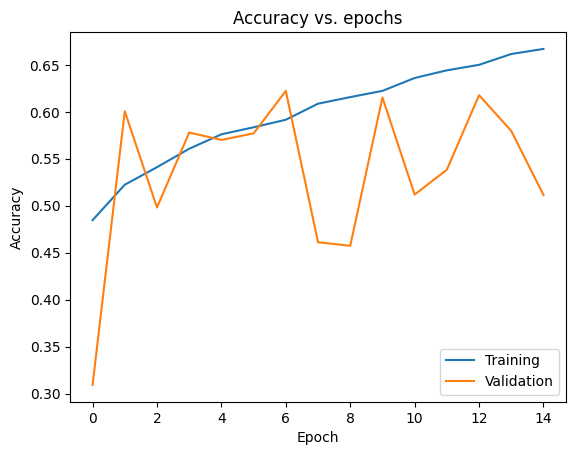

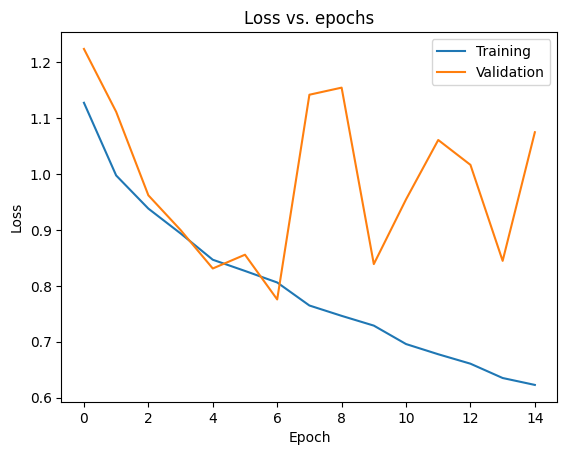

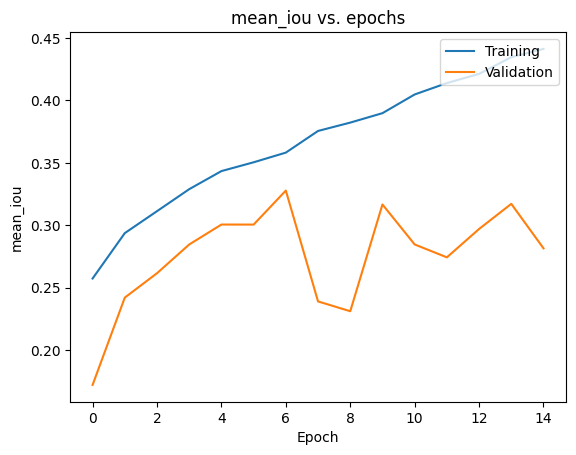

In [11]:
hp.plot_accuracy(dlab_history)
hp.plot_loss(dlab_history)
hp.plot_meaniou(dlab_history)

2023-05-10 01:06:20.505216: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-10 01:06:20.505248: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.64GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


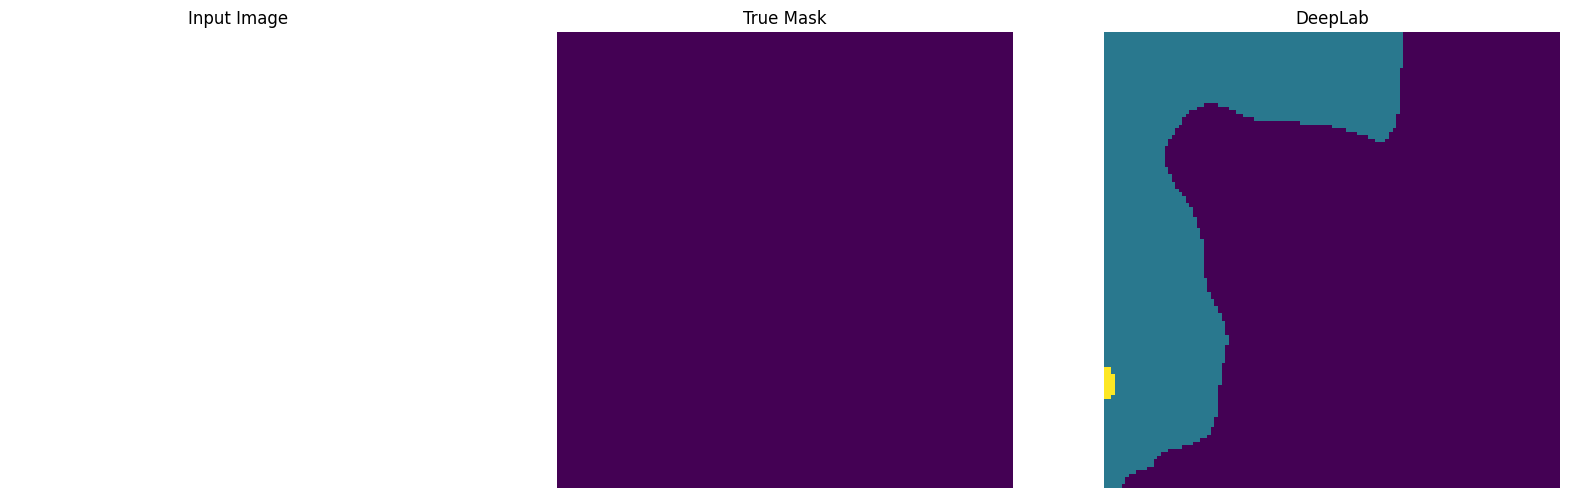

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


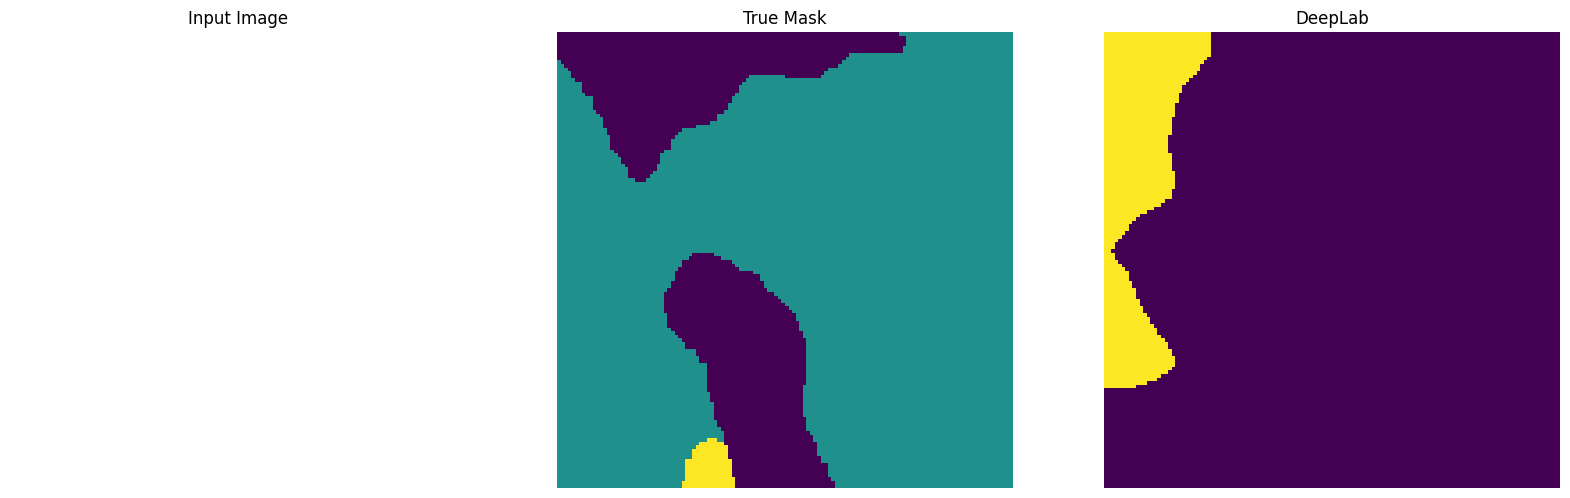

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


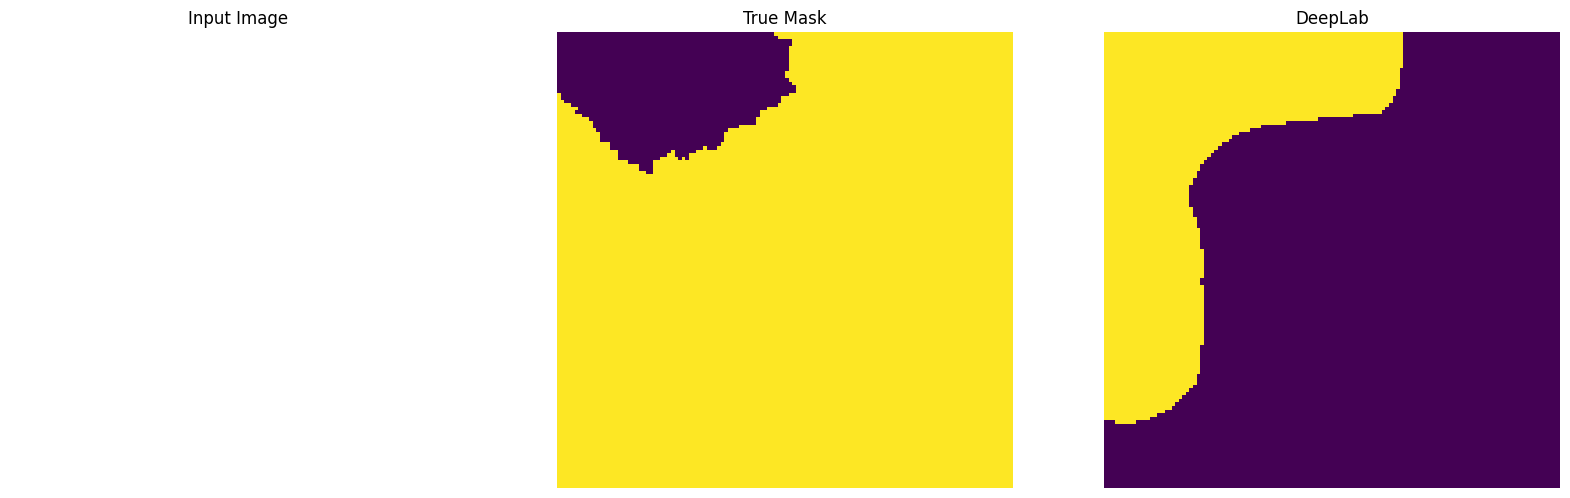

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


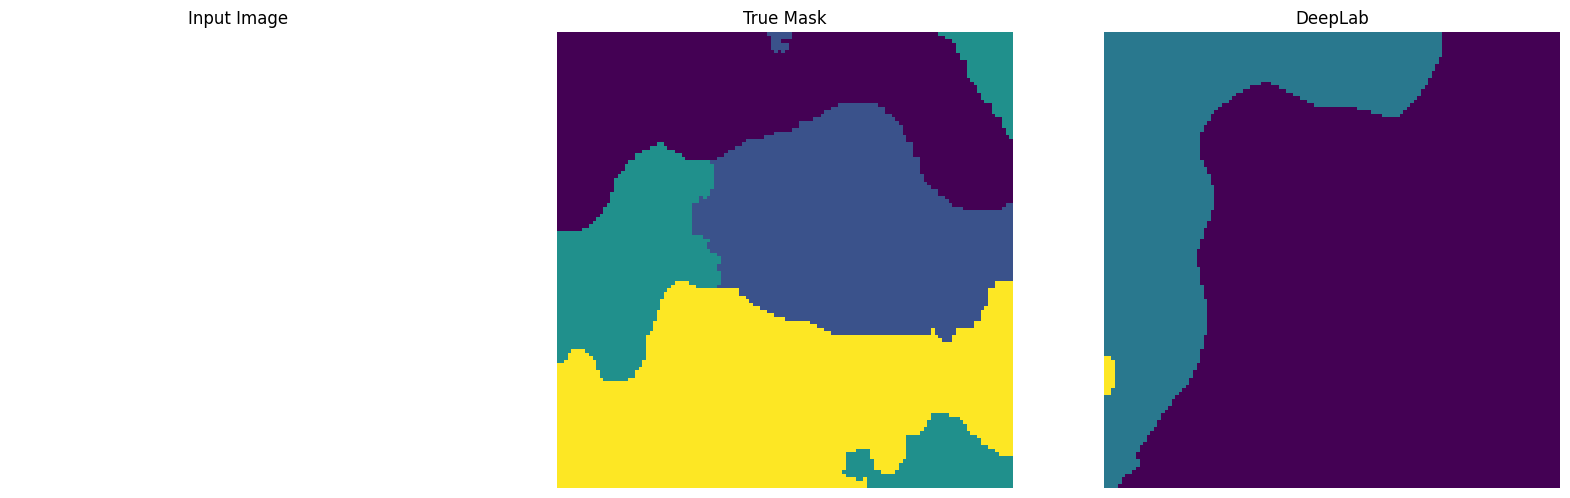

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


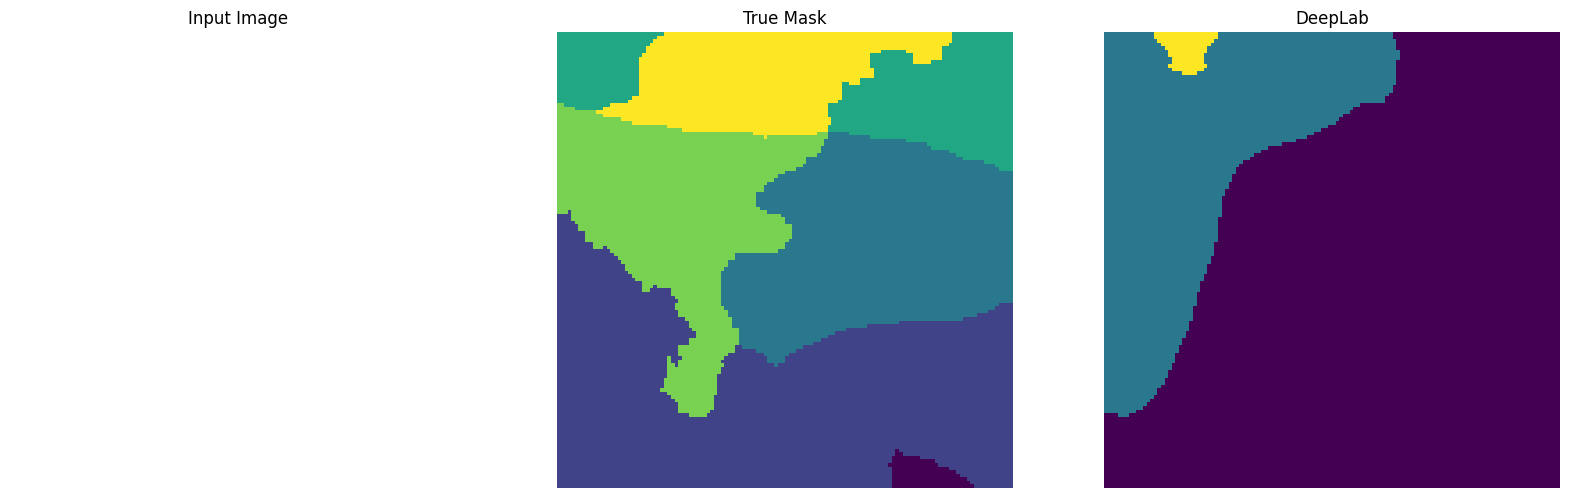

In [12]:
hp.show_predictions(model_deeplab, test_images[100:105], test_labels[100:105], 5, "DeepLab")

In [13]:
model_deeplab.save('Models/deeplabv3_seg_model_full_6class_PocketTubbs.tf', overwrite=True)

INFO:tensorflow:Assets written to: Models/deeplabv3_seg_model_full_6class_PocketTubbs.tf/assets


INFO:tensorflow:Assets written to: Models/deeplabv3_seg_model_full_6class_PocketTubbs.tf/assets


In [6]:
gc.collect()
svote_mask_tubbs = hp.voting(['deeplabv3_seg_model_full_6class_PocketNuns.tf',
                        'mobilenet_seg_model_full_6class_PocketNuns.tf',
                        'simple_seg_model_full_6class_PocketNuns.tf'],
                       Tubbs_images, Tubbs_labels, offset=25, num=5)

deeplabv3_seg_model_full_6class_PocketNuns.tf
mobilenet_seg_model_full_6class_PocketNuns.tf
simple_seg_model_full_6class_PocketNuns.tf
s_voting
0.33018968


2023-05-09 20:19:44.468269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 20:19:45.265071: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2023-05-09 20:19:45.265714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9457 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Models/deeplabv3_seg_model_full_6class_NunsTubbs.tf


2023-05-09 20:19:53.342632: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-05-09 20:20:02.579437: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-09 20:20:02.579465: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Models/mobilenet_seg_model_full_6class_NunsTubbs.tf
Models/simple_seg_model_full_6class_NunsTubbs.tf
s_votingcomplete: 99%
0.33337936


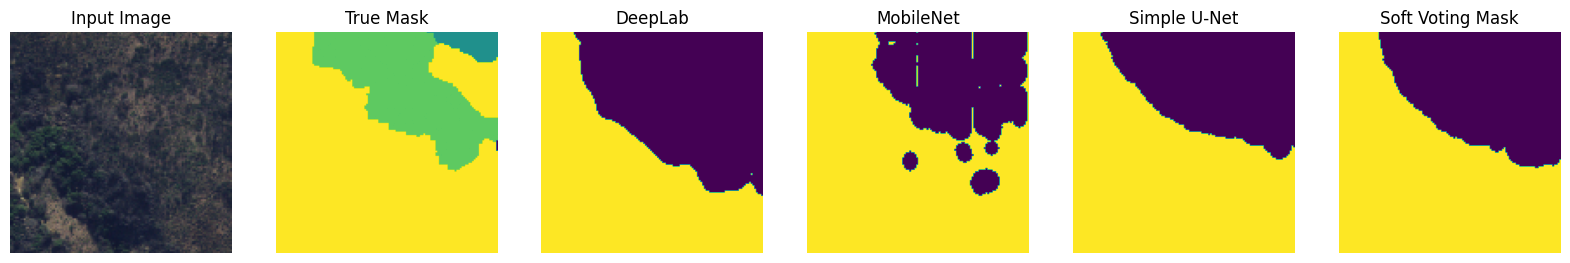

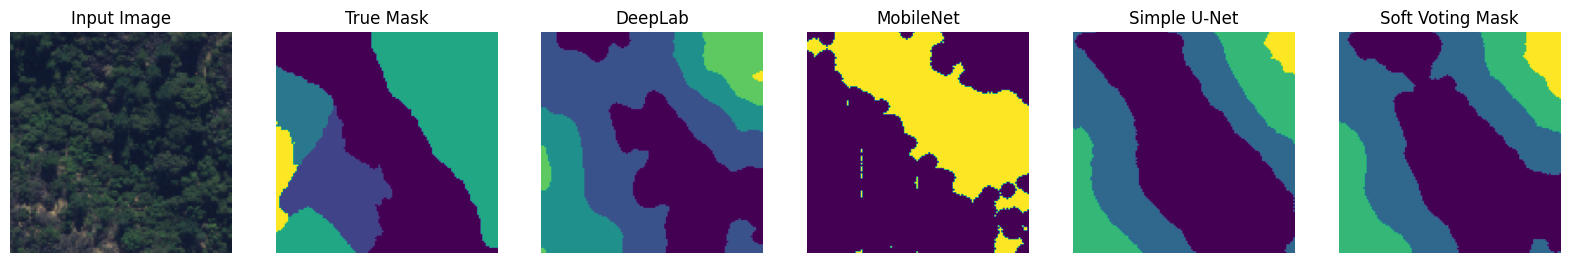

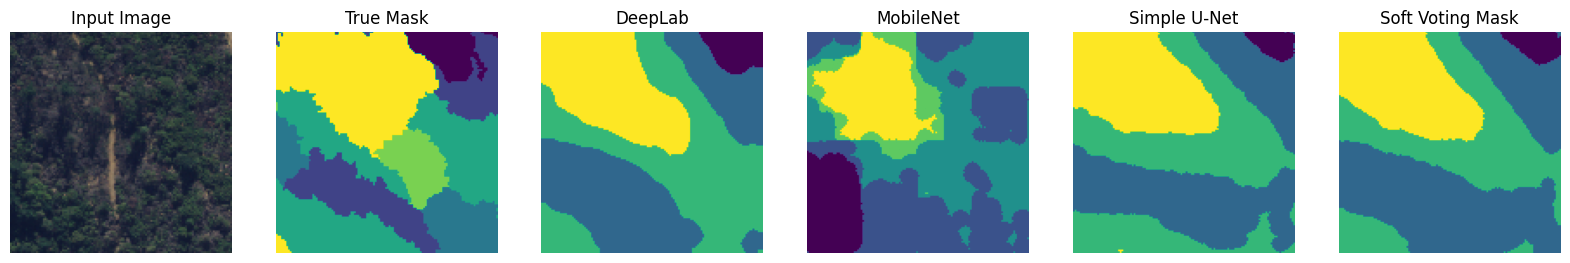

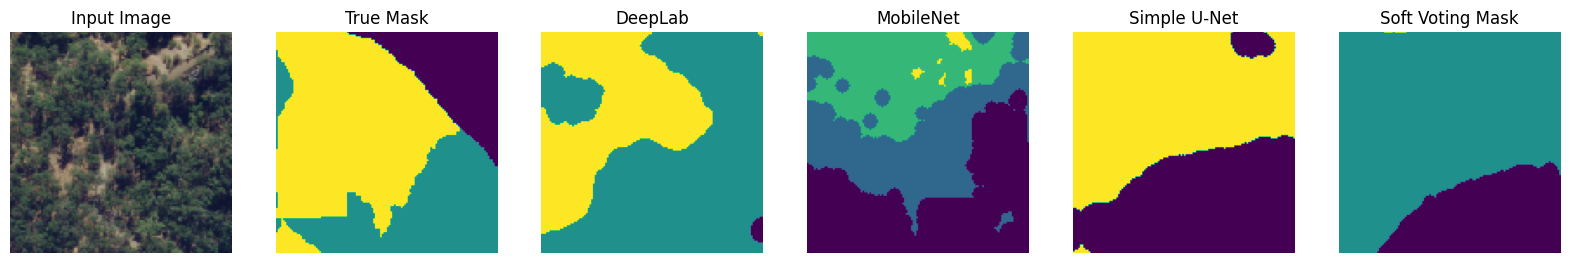

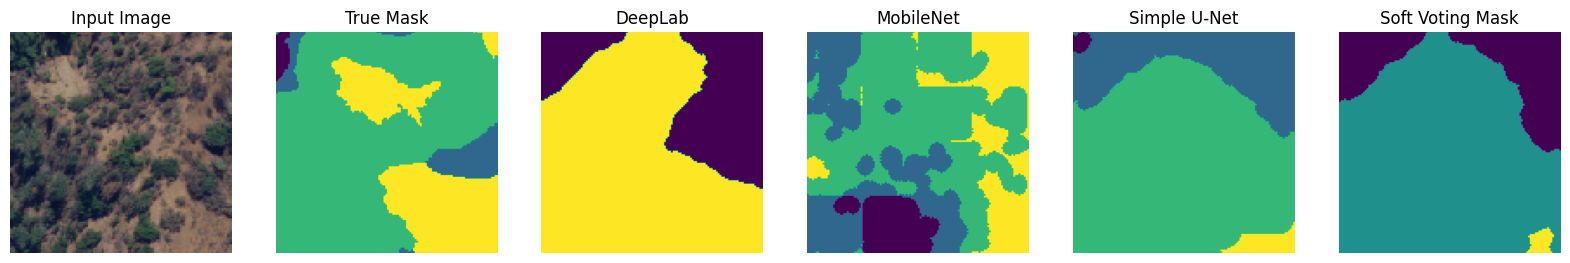

In [6]:
gc.collect()
svote_mask_Pocket = hp.voting(['Models/deeplabv3_seg_model_full_6class_NunsTubbs.tf',
                        'Models/mobilenet_seg_model_full_6class_NunsTubbs.tf',
                        'Models/simple_seg_model_full_6class_NunsTubbs.tf'],
                       Pocket_images, Pocket_labels, offset=25, num=5)

In [6]:
gc.collect()
svote_mask_Nuns = hp.voting(['Models/deeplabv3_seg_model_full_6class_PocketTubbs.tf',
                        'Models/mobilenet_seg_model_full_6class_PocketTubbs.tf',
                         'Models/simple_seg_model_full_6class_PocketTubbs.tf'],
                       Nuns_images, Nuns_labels, offset=25, num=5)

2023-05-10 11:04:38.589096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 11:04:39.387378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2023-05-10 11:04:39.388031: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9384 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Models/deeplabv3_seg_model_full_6class_PocketTubbs.tf


2023-05-10 11:04:48.871361: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-05-10 11:05:04.301064: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-10 11:05:04.301095: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.60GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-10 11:05:04.320089: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_427_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[13663,128,128,6] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

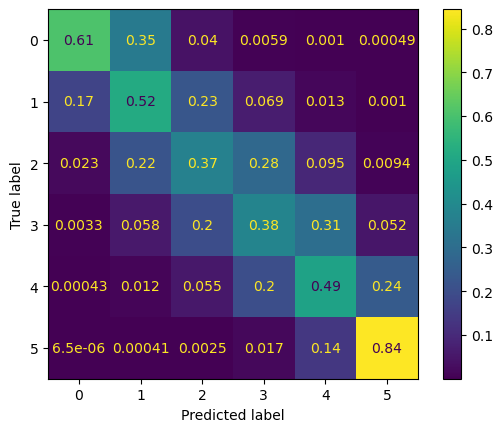

In [9]:
flat_preds = np.concatenate(svote_mask_tubbs).flatten()
flat_truth = np.concatenate(Tubbs_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

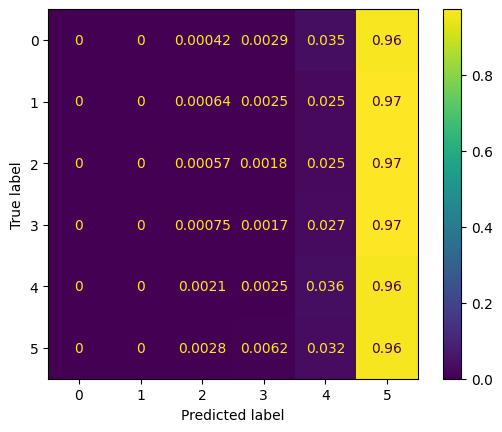

In [11]:
gc.collect()
flat_preds = np.concatenate(svote_mask_Pocket).flatten()
flat_truth = np.concatenate(Pocket_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

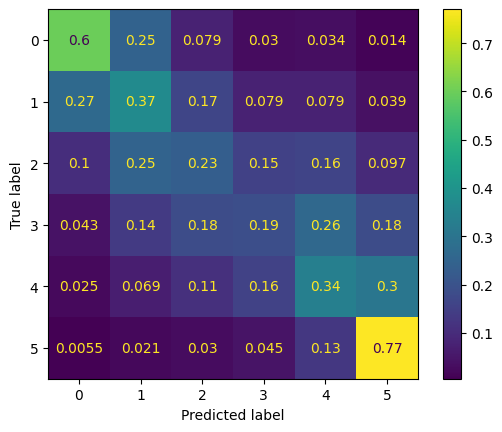

In [81]:
gc.collect()
flat_preds = np.concatenate(svote_mask_Nuns).flatten()
flat_truth = np.concatenate(Nuns_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [12]:
#final_images = np.concatenate(Pocket_images,Tubbs_images,Nuns_images, axis =0)
final_labels = np.concatenate((Pocket_labels,Tubbs_labels,Nuns_labels), axis =0)
svote_mask_final = np.concatenate((svote_mask_Pocket,svote_mask_tubbs,svote_mask_Nuns), axis = 0)

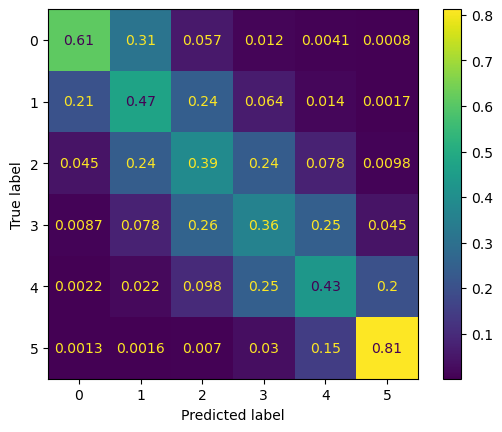

In [13]:
gc.collect()
flat_preds = np.concatenate(svote_mask_final).flatten()
flat_truth = np.concatenate(final_labels).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [14]:
np.unique(final_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([ 58714287,  75771302,  58164755,  41895012,  39142878, 234117462],
       dtype=int64))

In [15]:
svote_mask_final_bin = np.copy(svote_mask_final)
final_labels_bin = np.copy(final_labels)

In [16]:
flat_preds = np.concatenate(svote_mask_final_bin).flatten()
flat_truth = np.concatenate(final_labels_bin).flatten()

In [17]:
print(np.unique(flat_preds))
print(np.unique(flat_truth))

[0 1 2 3 4 5]
[0 1 2 3 4 5]


In [18]:
preds0 = np.where(flat_preds==0)
preds12 = np.where((flat_preds==1) | (flat_preds==2))
preds34 = np.where((flat_preds==3) | (flat_preds==4))
preds5 = np.where(flat_preds==5)

In [51]:
print(preds34)
print(preds5)
print(preds12)
print(preds0)

(array([    16444,     16445,     16446, ..., 507729404, 507729405,
       507729406], dtype=int64),)
(array([   196608,    196609,    196610, ..., 507805693, 507805694,
       507805695], dtype=int64),)
(array([        0,         1,         2, ..., 507007489, 507007491,
       507007617], dtype=int64),)
(array([   114693,    114694,    114695, ..., 502103980, 502103981,
       502103982], dtype=int64),)


In [19]:
flat_preds[preds0]=0
flat_preds[preds12]=1
flat_preds[preds34]=2
flat_preds[preds5]=3

In [20]:
truth0 = np.where((flat_truth == 0))
truth12 = np.where((flat_truth == 1) | (flat_truth == 2))
truth34 = np.where((flat_truth == 3) | (flat_truth == 4))
truth5 = np.where((flat_truth == 5))
flat_truth[truth0]=0
flat_truth[truth12] = 1
flat_truth[truth34] = 2
flat_truth[truth5] = 3

In [21]:
print(flat_truth.shape)

(507805696,)


In [22]:
print(flat_preds.shape)

(507805696,)


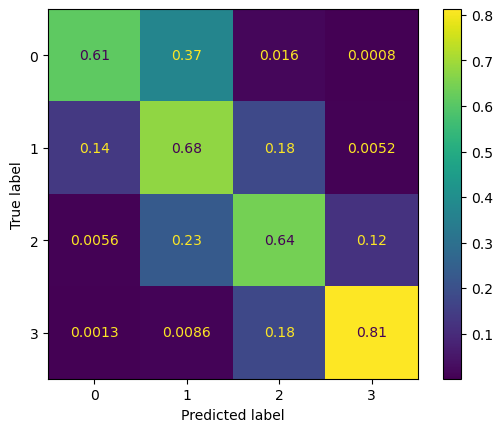

In [23]:
gc.collect()
# flat_preds = np.concatenate(svote_mask_final_bin).flatten()
# flat_truth = np.concatenate(final_labels_bin).flatten()
OUTPUT_CHANNELS = 4
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))
ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

In [ ]:
# Class   Damage
# 0	    <%5
# 1 	5%-20%
# 2	    20%-40%
# 3	    40%-60%
# 4	    60%-80%
# 5	    80%-100%

ARG